In [10]:
import torchvision
from research_task_utils import *
import importlib
from torchsummary import summary

# importlib.reload(research_task_utils)

In [2]:
batchsize = 512
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)
traindata = torchvision.datasets.CIFAR100(root="./dataset", train=True, download=True, transform=transform)
testdata = torchvision.datasets.CIFAR100(root="./dataset", train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
from collections import OrderedDict
class ConvBlock(torch.nn.Module):
    def __init__(self, num_of_convs, c_in, c_out, wh):
        super().__init__()
        
        self.num_of_convs = num_of_convs
        self.c_in = c_in
        self.c_out = c_out
        self.wh = wh
        
        layers = []
        
        assert num_of_convs > 0
        layers.append(('conv1',torch.nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1)))
        for k in range(1, num_of_convs):
            layers.append((f'relu_{k}',torch.nn.ReLU()))
            layers.append((f'conv_{k+1}',torch.nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1)))
            
        layers.append(('bn',torch.nn.BatchNorm2d(c_out)))
        layers.append((f'relu_{num_of_convs}',torch.nn.ReLU()))
        
        self.layers = torch.nn.Sequential(OrderedDict(layers))
        
    def num_of_params(self, only_trainable: bool = False):
        parameters = list(self.parameters())
        if only_trainable:
            parameters = [p for p in parameters if p.requires_grad]
        unique = {p.data_ptr(): p for p in parameters}.values()
        return sum(p.numel() for p in unique)
        
    def forward(self, x):
        return self.layers(x)
    


In [4]:
def num_of_convBlock_params(num_of_convs, c_in, c_out, wh):
    num = c_in*c_out*9 + c_out # first conv layer
    num += (num_of_convs - 1)*(c_out*c_out*9 + c_out) # other conv layers
    num += 2*c_out # BN params
    return num

class architecture():
    def __init__(self, c, k1, k2, k3, k4):
        self.c = c
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.k4 = k4
        
        self.num_of_params = (num_of_convBlock_params(num_of_convs=k1, c_in=3, c_out=c, wh=32) +
                              num_of_convBlock_params(num_of_convs=k2, c_in=c, c_out=2*c, wh=16) +
                              num_of_convBlock_params(num_of_convs=k3, c_in=2*c, c_out=4*c, wh=8) +
                              num_of_convBlock_params(num_of_convs=k4, c_in=4*c, c_out=8*c, wh=4) +
                              8*c*100+100)
        
    def get_num_of_params(self):
        return self.num_of_params

In [27]:
arch = architecture(c=10, k1=1, k2=1, k3=1, k4=1)
arch.get_num_of_params()

46620

In [46]:
architectures = []

for c in range(1, 51):
    for k12 in range(1, 10):
        for k34 in range(1, 10):
            arch = architecture(c, k12, k12, k34, k34)
            n_p = arch.get_num_of_params()
            if (n_p > 9000) and (n_p <= 10000):
                architectures.append((c, k12, k12, k34, k34))

In [49]:
architectures

[(2, 1, 1, 3, 3),
 (2, 2, 2, 3, 3),
 (2, 3, 3, 3, 3),
 (2, 4, 4, 3, 3),
 (2, 5, 5, 3, 3),
 (3, 8, 8, 1, 1),
 (3, 9, 9, 1, 1),
 (4, 1, 1, 1, 1)]

In [35]:
class ConvArchitecture1(torch.nn.Module):
    def __init__(self, model_hyperparams):
        super().__init__()
        
        c, k1, k2, k3, k4 = model_hyperparams
        self.hyperparams = model_hyperparams
        
        self.layers = torch.nn.Sequential(
            ConvBlock(num_of_convs=k1, c_in=3, c_out=c, wh=32),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k2, c_in=c, c_out=2*c, wh=16),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k3, c_in=2*c, c_out=4*c, wh=8),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k4, c_in=4*c, c_out=8*c, wh=4),
            
            torch.nn.AvgPool2d(kernel_size=4),
            torch.nn.Flatten(),
            torch.nn.Linear(8*c, 100),
            torch.nn.Softmax(dim=-1)
        )
    
    def num_of_params(self, only_trainable: bool = False):
        parameters = list(self.parameters())
        if only_trainable:
            parameters = [p for p in parameters if p.requires_grad]
        unique = {p.data_ptr(): p for p in parameters}.values()
        return sum(p.numel() for p in unique)

    def forward(self, x):
        return self.layers(x)

In [52]:
model = ConvArchitecture1(architectures[0][:5])
model = model.to(device)
print(architectures[0])
optimizer = torch.optim.Adam(model.parameters())
loss_function = torch.nn.CrossEntropyLoss()
statistics_list = init_statistics(model, device, trainloader, testloader, loss_function)

(2, 1, 1, 3, 3)


In [57]:
train(model, device, optimizer, loss_function, trainloader, testloader, statistics_list, epochs_n=80,
      augmenter=None, checkpoints_dir=None)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [11:42<00:00,  8.78s/it]


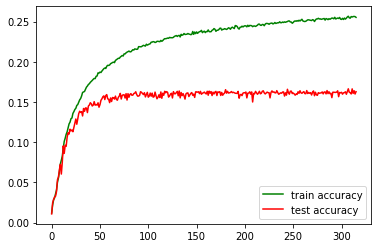

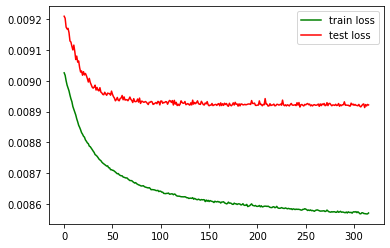

In [61]:
plot_statistics(statistics_list)

## Поиск гиперпараметров модели с помощью градиентных методов

In [1]:
# в этом эксперименте модели параметризуются значениями c, k12, k34

# хотим понять направление градиента от accuracy по этим параметрам,
# найти его проекцию на гиперповерхность N = const (N - количество параметров (весов) модели)
# и двигаться вдоль этой проекции

# градиенты будем вычислять численно, с помощью "разности вперед"
# для этого понадобятся модели со следующими параметрами

c = 1
k12 = 1
k34 = 1

architectures = [(c, k12, k34), (c+1, k12, k34), (c, k12+1, k34), (c, k12, k34+1)]

In [84]:
import statistics
import json
import os

def add_statistics_to_json(model_info, statistics_dict, path):
    if not os.path.exists(path):
        with open(path, 'w') as f:
            json.dump([{"model_info": model_info, "statistics": statistics_dict}], f)
    else:
        with open(path) as f:
            old_data = json.load(f)
        with open(path, 'w') as f:
            json.dump(old_data+[{"model_info": model_info, "statistics": statistics_dict}], f)
    

def perform_experiment(device, trainloader, testloader, Model_class, model_hyperparams, epochs_n, repeats_n):
    train_accs = []
    test_accs = []
    
    for k in range(repeats_n):
        model = Model_class(model_hyperparams).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        loss_function = torch.nn.CrossEntropyLoss()
        statistics_list = init_statistics(model, device, trainloader, testloader, loss_function)
        train(model, device, optimizer, loss_function, trainloader, testloader, statistics_list, epochs_n=epochs_n)
        train_accs.append(statistics_list["trainacc"][-1])
        test_accs.append(statistics_list["testacc"][-1])
        
        print("=================")
        print("Architecture: ", model_hyperparams)
        print("test acc:", statistics_list['testacc'][-1])
        plot_statistics(statistics_list)
        add_statistics_to_json(model_info={"name": "architecture1", "configuration": model_hyperparams,
                                           "comment": "first gridsearch, 75 epochs"},
                               statistics_dict=statistics_list,path="models_logs.json")
        print("=================")
        
    if repeats_n != 1:
        test_accs_std = statistics.stdev(test_accs)
        train_accs_std = statistics.stdev(train_accs)
    else:
        test_accs_std, train_accs_std = 0, 0
        
    result = {"train_acc_mean": statistics.mean(train_accs),
              "train_acc_std": train_accs_std,
              "test_acc_mean": statistics.mean(test_accs),
              "test_acc_std": test_accs_std,
              "num_of_params": model.num_of_params()
             }
    if repeats_n == 1:
        result["statistics"] = statistics_list
    return result


def perform_experiments(device, trainloader, testloader, Model_class, hyperparams_list, epochs_n, repeats_n):
    results = dict()
    for hyperparam in hyperparams_list:
        results[hyperparam] = perform_experiment(device, trainloader, testloader,
                                                   Model_class, hyperparam, epochs_n, repeats_n)
    return results

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [11:31<00:00,  9.21s/it]


Architecture:  (2, 1, 1, 3, 3)
test acc: 0.1547


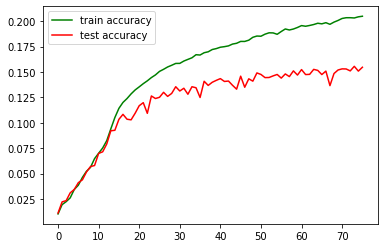

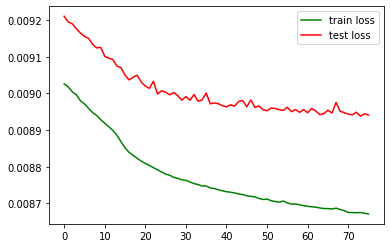

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [12:57<00:00, 10.37s/it]

Architecture:  (2, 2, 2, 3, 3)
test acc: 0.1359


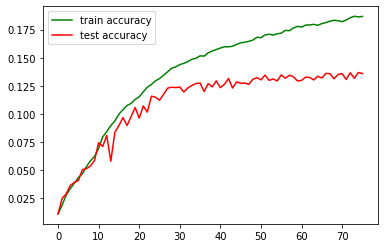

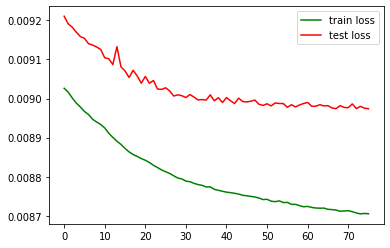

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [15:34<00:00, 12.46s/it]

Architecture:  (2, 3, 3, 3, 3)
test acc: 0.1274


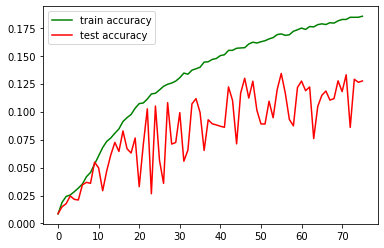

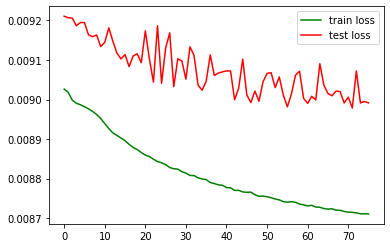

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [17:13<00:00, 13.78s/it]

Architecture:  (2, 4, 4, 3, 3)
test acc: 0.1426


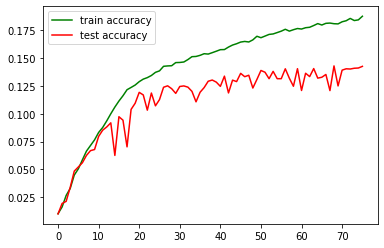

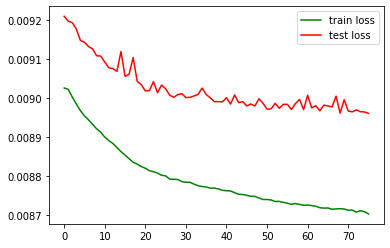

 56%|████████████████████████████████████████████▏                                  | 42/75 [10:13<07:57, 14.46s/it]

In [ ]:
hyperparams_list = architectures
results = perform_experiments(device, trainloader, testloader,
                              ConvArchitecture1, hyperparams_list, epochs_n=75, repeats_n=1)

# test_accs = []
# nums_of_params = []
# for hyperparam in hyperparams_list:
#     test_accs.append(results[hyperparam]["test_acc_mean"])
#     nums_of_params.append(results[hyperparam]["num_of_params"])
    
# plt.plot(nums_of_params, test_accs, marker='o')
# plt.show()

In [22]:
import statistics
import json

path = "models_logs.json"
with open(path) as f:
    logs = json.load(f)
    
initial_hyperparams = (c, k12, k34)

data_to_compute_gradients = {}
for log in logs:
    configuration = log["model_info"]["configuration"]
    c, k1, k2, k3, k4 = tuple(configuration)
    num_of_params = architecture(c, k1, k2, k3, k4).get_num_of_params()
    acc_avg = statistics.mean(log["statistics"]["testacc"][-10:])
    data_to_compute_gradients[tuple(configuration)] =  (num_of_params, acc_avg)

In [23]:
data_to_compute_gradients

{(2, 1, 1, 3, 3): (9164, 0.15064),
 (2, 2, 2, 3, 3): (9350, 0.13455),
 (2, 3, 3, 3, 3): (9536, 0.1187),
 (2, 4, 4, 3, 3): (9722, 0.13685),
 (2, 5, 5, 3, 3): (9908, 0.11424000000000001),
 (3, 8, 8, 1, 1): (9016, 0.11016),
 (3, 9, 9, 1, 1): (9430, 0.08669),
 (4, 1, 1, 1, 1): (9636, 0.19906)}

In [ ]:
def get_N(hyperparams, data_to_compute_gradients):
    return data_to_compute_gradients[(hyperparams[0], hyperparams[1], hyperparams[1],
                                      hyperparams[2], hyperparams[2])][0]
def get_acc(hyperparams, data_to_compute_gradients):
    return data_to_compute_gradients[(hyperparams[0], hyperparams[1], hyperparams[1],
                                      hyperparams[2], hyperparams[2])][1]

def get_grad_N(hyperparams, data_to_compute_gradients):
    grad = []
    for i in range(len(hyperparams)):
        hyperparams_tmp = list(hyperparams)
        hyperparams_tmp[i] += 1
        grad.append(get_N(hyperparams_tmp, data_to_compute_gradients) 
                    - get_N(hyperparams, data_to_compute_gradients))
    return np.array(grad)

def get_grad_acc(hyperparams, data_to_compute_gradients):
    grad = []
    for i in range(len(hyperparams)):
        hyperparams_tmp = list(hyperparams)
        hyperparams_tmp[i] += 1
        grad.append(get_acc(hyperparams_tmp, data_to_compute_gradients) 
                    - get_acc(hyperparams, data_to_compute_gradients))
    return np.array(grad)

In [19]:
grad_N = get_grad_N(initial_hyperparams, data_to_compute_gradients)
grad_acc = get_grad_acc(initial_hyperparams, data_to_compute_gradients)

cosine = np.dot(grad_N, grad_acc) / np.linalg.norm(grad_N) / np.linalg.norm(grad_acc)
print(cosine)

direction_to_change_params = 

{(2, 1, 1, 3, 3): (9164, 0.15306),
 (2, 2, 2, 3, 3): (9350, 0.13432),
 (2, 3, 3, 3, 3): (9536, 0.12026),
 (2, 4, 4, 3, 3): (9722, 0.14104),
 (2, 5, 5, 3, 3): (9908, 0.10858),
 (3, 8, 8, 1, 1): (9016, 0.10974)}